# Industrial Applications of Artificial Intelligence

### This notebook will give an overview on the datasets and algorithms that will be used for the first hand-in regarding the primary sector wind in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Agriculture is a very important sector of each country and humanity still highly relies on agriculture to generate food. For getting the best yield out of the crop farmers highly depend on monitoring and suggestions based on the crops along with external factors. The ultimate aim is to reduce the losses by providing rich recommendations & insights about the crops. But before providing any suggestions, the crop needs to be classified. Machine Learning can help with this. In the following we want to explore how the classification behaves with different sizes of data (original and original + augmented) and models.

In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization, Reshape, UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir, getcwd, system
from sklearn.metrics import multilabel_confusion_matrix
import os
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.image as mpimg
from sklearn.preprocessing import OneHotEncoder
from numpy import asarray
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn import svm
from sklearn.decomposition import PCA
from skimage.io import imread, imshow

## I. Import Data

The dataset can be found on kaggle unter the following [url](https://www.kaggle.com/datasets/aman2000jaiswal/agriculture-crop-images). The original imageset in the folder crop images contains 40 pictures for 5 different sorts of crop, in particular maize, wheate, jute, rice and sugarcane. This base set is complemented by a second file set including 160 augmented images per class. The augmentation methods consist of a horizontal flip, a rotation, a horizontal shift and a vertical shift. The folder some more images contains 10 further images per class that will be used as validation set. On top of that, we have already a given test set in the folder test_crop_image. We will not change the amount of the validation set throughout the experiments, to be able to capture the effect of the augmented data and make it comparable.

In a first step we want to load the data. We will use a predefined function for that, where we can directly specifiy the labels and the image size.

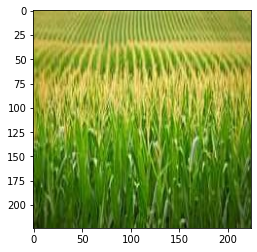

In [9]:
#Load on example picture of maize
path = "../../src/data/Abgabe_1_Crop_images/crop_images/maize/maize001a.jpeg"
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

In [10]:
#lets explore the image a bit
print("The image is stored in an", type(img), "of dimensions", img.shape)
print("The maximum value in the array is", np.max(img))
print("The minimum value is", np.min(img))

The image is stored in an <class 'numpy.ndarray'> of dimensions (224, 224, 3)
The maximum value in the array is 255
The minimum value is 0


We can clearly see that our pictures already have the dimensions 224,224,3. So, let's load the whole dataset.

In [2]:
def load_images(dir_path, labels, X, y, image_size):
    for s in labels:
        comp_path = dir_path+s+"/"
        list_of_images = os.listdir(comp_path)
        for i in list_of_images:
            img = image.load_img(dir_path+s+"/"+i, target_size=image_size)
            img = image.img_to_array(img)
            img = img/255
            X.append(img)
            y.append(s)

    X = np.array(X)
    return X, y

In [4]:
X_train = []
y_train = []
dir_path ='../../src/data/Abgabe_1_Crop_images/crop_images/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train, y_train = load_images(dir_path, labels, X_train, y_train, image_size)

X_val = []
y_val = []
dir_path_val = '../../src/data/Abgabe_1_Crop_images/some_more_images/'
labels_val = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_val, y_val = load_images(dir_path_val, labels_val, X_val, y_val, image_size)

print("I'm done!")

I'm done!


# II. First Baselines

In order to get some baselines to measure how good further models perform, we will make use of a classical SVM and a stupid use of a pretrained VGG classifier.

## SVM

For the SVM we will flatten the arrays first.

In [18]:
X_train_flat = [x.flatten() for x in X_train]
X_val_flat = [x.flatten() for x in X_val]

In [2]:
# We make use of a predefined SVM standard implementation of the exercise
def svm_model(X_train, y_train, X_val, y_val):
    model = svm.SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    return model

In [20]:
model = svm_model(X_train_flat, y_train, X_val_flat, y_val)

Accuracy: 0.28
[[3 1 1 5 0]
 [1 1 1 7 0]
 [1 2 1 5 1]
 [0 1 2 7 0]
 [0 3 4 1 2]]


We can clearly see that the model has a clear tendency to predict sugarcane and is cleary not good yet. So lets try to extend our data by using the augmented data as well.

In [24]:
X_train_augmented = []
y_train_augmented = []
dir_path ='../../src/data/Abgabe_1_Crop_images/kag2/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train_augmented, y_train_augmented = load_images(dir_path, labels, X_train_augmented, y_train_augmented, image_size)

print("I'm done!")

I'm done!


In [27]:
#Construct a new training set containing both normal and augmetented 
X_train_enhanced = np.concatenate((X_train, X_train_augmented))
y_train_enhanced = np.concatenate((y_train, y_train_augmented))

In [29]:
print(len(X_train_enhanced))
print(len(y_train_enhanced))

1005
1005


In [30]:
#flatten the values again
X_train_flat = [x.flatten() for x in X_train_enhanced]
X_val_flat = [x.flatten() for x in X_val]

In [32]:
model = svm_model(X_train_flat, y_train_enhanced, X_val_flat, y_val)

Accuracy: 0.38
[[4 1 2 3 0]
 [3 2 1 4 0]
 [1 5 2 1 1]
 [0 2 1 7 0]
 [0 2 3 1 4]]


We see that this improves our model, but we are still far from a good result. In order to not only focus on normal models, we want to get a neural network baseline as well and therefor make use of a pretrained VGG implementation that is based on a convolutional neural network architecture..

## VGG

To be able to use the labels in a neural network, we need to one hot encode them first.

In [40]:
# one hot encode the labels for without augmented and with augmented
y_train_res = asarray(y_train).reshape(-1, 1)
y_val_res = asarray(y_val).reshape(-1, 1)
y_train_res_enhanced = asarray(y_train_enhanced).reshape(-1, 1)


oh_enc = OneHotEncoder(sparse=False)

y_train_onehot = oh_enc.fit_transform(y_train_res)
y_val_onehot = oh_enc.transform(y_val_res)
y_train_onehot_augmented_enhanced = oh_enc.fit_transform(y_train_res_enhanced)
y_val_onehot_augmented = oh_enc.transform(y_val_res)

print("Original Label:", y_train[0])
print("One-Hot Label:", y_train_onehot[0])

Original Label: jute
One-Hot Label: [1. 0. 0. 0. 0.]


Initialise a first model.

In [34]:
# use the variant withput further training and Leave out the last fully connected layer
vgg16_without_top_layer = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg16_without_top_layer.trainable = False
vgg16_without_top_layer.summary()

base_model_vg16 = VGG16(input_shape = (224, 224, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')
base_model_vg16.trainable = False

# Flatten the output layer to 1 dimension to be able to build on top of it
flat = Flatten()(vgg16_without_top_layer.layers[-1].output)
dense1 = Dense(256, activation="relu")(flat)
#adjust the ouptut layer to 5 clases
output = Dense(5, activation="softmax")(dense1)

model_transfer_learning = Model(inputs = vgg16_without_top_layer.inputs, outputs = output)
model_transfer_learning.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#compile the model
model_transfer_learning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [38]:
#small batch size for our initial set
model_transfer_learning_history = model_transfer_learning.fit(X_train, y_train_onehot, batch_size=8,epochs=15,verbose=1,validation_data=(X_val, y_val_onehot), callbacks=[callback])

Epoch 1/15
26/26 [==============================] - 85s 3s/step - loss: 0.7052 - accuracy: 0.7413 - val_loss: 1.5858 - val_accuracy: 0.3400
Epoch 2/15
26/26 [==============================] - 86s 3s/step - loss: 0.4424 - accuracy: 0.8507 - val_loss: 1.4386 - val_accuracy: 0.4800
Epoch 3/15
26/26 [==============================] - 80s 3s/step - loss: 0.2245 - accuracy: 0.9652 - val_loss: 1.6203 - val_accuracy: 0.4400
Epoch 4/15
26/26 [==============================] - 99s 4s/step - loss: 0.1526 - accuracy: 0.9851 - val_loss: 1.5770 - val_accuracy: 0.4200
Epoch 5/15
26/26 [==============================] - 103s 4s/step - loss: 0.0789 - accuracy: 0.9950 - val_loss: 1.5102 - val_accuracy: 0.4800


In [41]:
#higher batch size for our augmented set
model_transfer_learning_history = model_transfer_learning.fit(X_train_enhanced, y_train_onehot_augmented_enhanced, batch_size=32,epochs=15,verbose=1,validation_data=(X_val, y_val_onehot_augmented), callbacks=[callback])

Epoch 1/15
32/32 [==============================] - 325s 10s/step - loss: 0.2781 - accuracy: 0.9333 - val_loss: 1.3859 - val_accuracy: 0.5000
Epoch 2/15
32/32 [==============================] - 319s 10s/step - loss: 0.1394 - accuracy: 0.9821 - val_loss: 1.3013 - val_accuracy: 0.5200
Epoch 3/15
32/32 [==============================] - 281s 9s/step - loss: 0.0918 - accuracy: 0.9920 - val_loss: 1.3459 - val_accuracy: 0.5400
Epoch 4/15
32/32 [==============================] - 265s 8s/step - loss: 0.0590 - accuracy: 0.9980 - val_loss: 1.3806 - val_accuracy: 0.5600
Epoch 5/15
32/32 [==============================] - 258s 8s/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 1.5349 - val_accuracy: 0.5800


We can clearly see that the neural networks are far better in capturing the pictures than the SVMS. Even the smaller version beats the augmented SVM version. So letts first try to increase the performance of the SVM. 

## III. SVM extensive training

### III.I Smaller Dataset

We will first us PCA and autoencoders reduce the dimensions and extract only meaningful features.

In [51]:
# first flatten the data again
X_train_flat = [x.flatten() for x in X_train]
X_val_flat = [x.flatten() for x in X_val]

In [64]:
#we will use PCA to extract the features that explain at least 80 percent of the variance
pca = PCA(n_components=0.9, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_flat)
#use pca also on validation set, but withput further fitting
X_val_pca = pca.transform(X_val_flat)

In [65]:
print(len(X_train_pca[0]))
print(len(X_train[0]))

101
224


In [66]:
model = svm_model(X_train_pca, y_train, X_val_pca, y_val)

Accuracy: 0.34
[[4 1 1 4 0]
 [1 1 1 7 0]
 [1 0 1 7 1]
 [0 0 2 8 0]
 [0 1 4 2 3]]


We were able to reduce the feature size by more than half, while still keeping good results only by pca. Lets extract features with an autoencoder aswell and use them as further input.

### Autoencoder

We will use the version of the network presented in the exercise, as the dimensions fit perfectly. The autoencoder gets the same data as input and output, cause we want to learn a meaningful representation of the data.

In [96]:
autoencoder = Sequential()
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape = (224,224,3)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = (224,224,3)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Flatten())
autoencoder.add(Dense(256, activation="relu"))
autoencoder.add(Dense(64, activation="relu")) #end of the encoding part
autoencoder.add(Dense(256, activation="relu")) #start of the decoding part
autoencoder.add(Dense(np.prod((14,14,128)), activation='linear'))
autoencoder.add(Reshape((14, 14, 128)))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [97]:
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder_history = autoencoder.fit(X_train, X_train, batch_size=32,epochs=10,verbose=1,validation_data=(X_val, X_val))

Epoch 1/10
7/7 [==============================] - 28s 4s/step - loss: 0.0616 - val_loss: 0.0635
Epoch 2/10
7/7 [==============================] - 31s 4s/step - loss: 0.0509 - val_loss: 0.0606
Epoch 3/10
7/7 [==============================] - 31s 4s/step - loss: 0.0488 - val_loss: 0.0553
Epoch 4/10
7/7 [==============================] - 30s 4s/step - loss: 0.0464 - val_loss: 0.0478
Epoch 5/10
7/7 [==============================] - 30s 4s/step - loss: 0.0449 - val_loss: 0.0452
Epoch 6/10
7/7 [==============================] - 30s 4s/step - loss: 0.0451 - val_loss: 0.0452
Epoch 7/10
7/7 [==============================] - 29s 4s/step - loss: 0.0420 - val_loss: 0.0439
Epoch 8/10
7/7 [==============================] - 30s 4s/step - loss: 0.0399 - val_loss: 0.0505
Epoch 9/10
7/7 [==============================] - 29s 4s/step - loss: 0.0410 - val_loss: 0.0433
Epoch 10/10
7/7 [==============================] - 28s 4s/step - loss: 0.0395 - val_loss: 0.0408


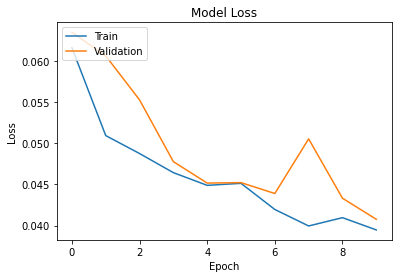

In [99]:
# have a look at the training
plt.plot(autoencoder_history.history['loss'])
plt.plot(autoencoder_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
autoencoder.save("autoencoderv_1.h5")

In [100]:
# extract the features from the autoencoder
autoencoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 28, 28, 128)     

In [102]:
encoder_output = autoencoder.get_layer("dense_57").output
encoder = Model(inputs = autoencoder.input, outputs = encoder_output)
encoded_data_train = encoder.predict(X_train)
encoded_data_val = encoder.predict(X_val)

In [103]:
#use only the representation of the autoencoder as input
model = svm_model(encoded_data_train, y_train, encoded_data_val, y_val)

Accuracy: 0.2
[[4 1 3 1 1]
 [4 0 2 3 1]
 [4 0 3 2 1]
 [2 1 4 2 1]
 [1 0 5 3 1]]


We see that the autoencoder is not able to capture a good representation on its own. Seems like, we do not have enough data for that. Now let's combine both representations PCA and autoencoder.

In [124]:
# we will merge the two representations
encoded_pca_train = []
encoded_pca_val = []

for i in range(len(encoded_data_train)):
    encoded_pca_train.append(np.concatenate((encoded_data_train[i], X_train_pca[i]), axis=None))
for i in range(len(encoded_data_val)):
    encoded_pca_val.append(np.concatenate((encoded_data_val[i], X_val_pca[i]), axis=None))
encoded_pca_train = np.array(encoded_pca_train)
encoded_pca_val = np.array(encoded_pca_val)

In [125]:
print(len(encoded_pca_train))
print(len(encoded_pca_val))

201
50


In [127]:
#use only the representation of the autoencoder as input
model = svm_model(encoded_pca_train, y_train, encoded_pca_val, y_val)

Accuracy: 0.34
[[4 1 1 4 0]
 [1 1 1 7 0]
 [1 0 1 7 1]
 [0 0 2 8 0]
 [0 1 4 2 3]]


We see that it does not increase our information to get further information from the autoencoder. It seems like we do not have enough training for these features to be meaningful. Now lets try this approach for our with augmented images enhanced set.

### III.II Enhanced Dataset

We will first us PCA and autoencoders reduce the dimensions and extract only meaningful features.

In [128]:
# first flatten the data again
X_train_flat = [x.flatten() for x in X_train_enhanced]
X_val_flat = [x.flatten() for x in X_val]

In [129]:
#we will use PCA to extract the features that explain at least 80 percent of the variance
pca = PCA(n_components=0.9, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_flat)
#use pca also on validation set, but withput further fitting
X_val_pca = pca.transform(X_val_flat)

In [130]:
print(len(X_train_pca[0]))
print(len(X_train[0]))

153
224


In [132]:
model = svm_model(X_train_pca, y_train_enhanced, X_val_pca, y_val)

Accuracy: 0.36
[[4 0 2 4 0]
 [3 2 0 5 0]
 [1 4 2 2 1]
 [1 2 1 6 0]
 [0 2 3 1 4]]


We see that we get better results with 90% variance, although, we could not reduce the feature space as much, as in the smaller set. But that was to be expected, as we now have a richer set of features.

### Autoencoder

We will use the version of the network presented in the exercise, as the dimensions fit perfectly. The autoencoder gets the same data as input and output, cause we want to learn a meaningful representation of the data.

In [133]:
autoencoder = Sequential()
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape = (224,224,3)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = (224,224,3)))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder.add(Flatten())
autoencoder.add(Dense(256, activation="relu"))
autoencoder.add(Dense(64, activation="relu")) #end of the encoding part
autoencoder.add(Dense(256, activation="relu")) #start of the decoding part
autoencoder.add(Dense(np.prod((14,14,128)), activation='linear'))
autoencoder.add(Reshape((14, 14, 128)))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [135]:
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder_history = autoencoder.fit(X_train_enhanced, X_train_enhanced, batch_size=64,epochs=10,verbose=1,validation_data=(X_val, X_val))

Epoch 1/10
16/16 [==============================] - 175s 11s/step - loss: 0.0428 - val_loss: 0.0501
Epoch 2/10
16/16 [==============================] - 192s 12s/step - loss: 0.0357 - val_loss: 0.0393
Epoch 3/10
16/16 [==============================] - 207s 13s/step - loss: 0.0326 - val_loss: 0.0386
Epoch 4/10
16/16 [==============================] - 199s 12s/step - loss: 0.0285 - val_loss: 0.0366
Epoch 5/10
16/16 [==============================] - 253s 16s/step - loss: 0.0266 - val_loss: 0.0343
Epoch 6/10
16/16 [==============================] - 272s 17s/step - loss: 0.0254 - val_loss: 0.0327
Epoch 7/10
16/16 [==============================] - 297s 19s/step - loss: 0.0239 - val_loss: 0.0314
Epoch 8/10
16/16 [==============================] - 246s 15s/step - loss: 0.0225 - val_loss: 0.0303
Epoch 9/10
16/16 [==============================] - 212s 13s/step - loss: 0.0212 - val_loss: 0.0307
Epoch 10/10
16/16 [==============================] - 198s 12s/step - loss: 0.0201 - val_loss: 0.0290

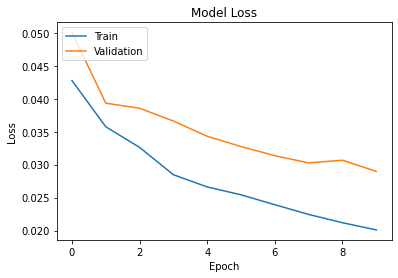

In [136]:
# have a look at the training
plt.plot(autoencoder_history.history['loss'])
plt.plot(autoencoder_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
autoencoder.save("autoencoder_enhanced_v1.h5")

In [137]:
# extract the features from the autoencoder
autoencoder.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 28, 28, 128)     

In [139]:
encoder_output = autoencoder.get_layer("dense_61").output
encoder = Model(inputs = autoencoder.input, outputs = encoder_output)
encoded_data_train = encoder.predict(X_train_enhanced)
encoded_data_val = encoder.predict(X_val)

In [140]:
#use only the representation of the autoencoder as input
model = svm_model(encoded_data_train, y_train_enhanced, encoded_data_val, y_val)

Accuracy: 0.38
[[4 1 3 2 0]
 [4 3 0 3 0]
 [1 3 1 4 1]
 [0 2 1 7 0]
 [0 1 2 3 4]]


We see that the autoencoder is now more able to capture a representation on its own. So, it seems that with more data, the encoder performs better, as expected. Now let's combine both representations PCA and autoencoder.

In [141]:
# we will merge the two representations
encoded_pca_train = []
encoded_pca_val = []

for i in range(len(encoded_data_train)):
    encoded_pca_train.append(np.concatenate((encoded_data_train[i], X_train_pca[i]), axis=None))
for i in range(len(encoded_data_val)):
    encoded_pca_val.append(np.concatenate((encoded_data_val[i], X_val_pca[i]), axis=None))
encoded_pca_train = np.array(encoded_pca_train)
encoded_pca_val = np.array(encoded_pca_val)

In [142]:
print(len(encoded_pca_train))
print(len(encoded_pca_val))

1005
50


In [143]:
#use only the representation of the autoencoder as input
model = svm_model(encoded_pca_train, y_train_enhanced, encoded_pca_val, y_val)

Accuracy: 0.36
[[4 0 2 4 0]
 [3 2 0 5 0]
 [1 4 2 2 1]
 [1 2 1 6 0]
 [0 2 3 1 4]]


We can see that the model gets better and performs in the same way as the baseline with only part of the data. It seems that for our amount of data pca is the better choice. So, for further tests we will only look at the enhanced pca-reduced dataset.

## III.3 Grey scale

In a next step we will try out the pca reduced settings with the pictures in grey and see if that will improve our model.

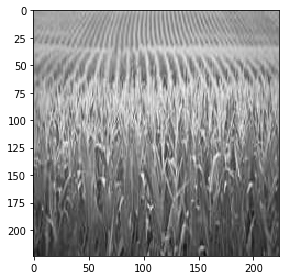

In [180]:
#Load on example picture of maize
path = "../../src/data/Abgabe_1_Crop_images/crop_images/maize/maize001a.jpeg"
image_grey = imread(path,as_gray=True)
imshow(image)

In [3]:
#import the data with predefined function
def load_images_gray(dir_path, labels, X, y):
    for s in labels:
        comp_path = dir_path+s+"/"
        list_of_images = os.listdir(comp_path)
        for i in list_of_images:
            img = image.load_img(dir_path+s+"/"+i, target_size=(224,224,3))
            img = img.convert('L')
            img = image.img_to_array(img)
            img = img/255
            X.append(img)
            y.append(s)

    X = np.array(X)
    return X, y

In [4]:
X_train = []
y_train = []
dir_path ='../../src/data/Abgabe_1_Crop_images/crop_images/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']

X_train, y_train = load_images_gray(dir_path, labels, X_train, y_train)

X_val = []
y_val = []
dir_path_val = '../../src/data/Abgabe_1_Crop_images/some_more_images/'
labels_val = ["jute", "maize", "rice",'sugarcane','wheat']

X_val, y_val = load_images_gray(dir_path_val, labels_val, X_val, y_val)

print("I'm done!")

I'm done!


In [7]:
X_train_augmented = []
y_train_augmented = []
dir_path ='../../src/data/Abgabe_1_Crop_images/kag2/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train_augmented, y_train_augmented = load_images_gray(dir_path, labels, X_train_augmented, y_train_augmented)

print("I'm done!")

I'm done!


In [8]:
#Construct a new training set containing both normal and augmetented 
X_train_enhanced = np.concatenate((X_train, X_train_augmented))
y_train_enhanced = np.concatenate((y_train, y_train_augmented))

In [9]:
# first flatten the data again
X_train_flat = [x.flatten() for x in X_train_enhanced]
X_val_flat = [x.flatten() for x in X_val]

In [10]:
#we will use PCA to extract the features that explain at least 80 percent of the variance
pca = PCA(n_components=0.9, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_flat)
#use pca also on validation set, but withput further fitting
X_val_pca = pca.transform(X_val_flat)

In [11]:
print(len(X_train_pca[0]))
print(len(X_train[0]))

164
224


In [12]:
model = svm_model(X_train_pca, y_train_enhanced, X_val_pca, y_val)

Accuracy: 0.26
[[3 1 4 2 0]
 [2 1 2 3 2]
 [0 3 2 4 1]
 [1 1 4 4 0]
 [1 0 5 1 3]]


We see that grey-scaling makes the model a lot worse, as it seems that it is less able to distinguish the crop then.

As the results for the SVM are not the promising and far worse than the first result of VGG, we will not try extensive hyperparameter tuning and will focus on CNNs and transfer learning in the following.

## IV. CNNs

To not get confused, we will reload the enhanced dataset here again.

In [13]:
def load_images(dir_path, labels, X, y, image_size):
    for s in labels:
        comp_path = dir_path+s+"/"
        list_of_images = os.listdir(comp_path)
        for i in list_of_images:
            img = image.load_img(dir_path+s+"/"+i, target_size=image_size)
            img = image.img_to_array(img)
            img = img/255
            X.append(img)
            y.append(s)

    X = np.array(X)
    return X, y

In [41]:
# function to evaluate the model
def evaluate_model(m, X, y):
    y_pred = m.predict(X)
    predicted_classes = np.argmax(y_pred,axis=1)
    
    predictions = []
    for i in predicted_classes:
        if i == 0:
            predictions.append("jute")
        elif i == 1:
            predictions.append("maize")
        elif i == 2:
            predictions.append("rice")
        elif i == 3:
            predictions.append("sugarcane")
        else:
            predictions.append("wheat")
    print("Accuracy:",metrics.accuracy_score(y, predictions))
    print(confusion_matrix(y, predictions))
    

In [14]:
X_train = []
y_train = []
dir_path ='../../src/data/Abgabe_1_Crop_images/crop_images/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train, y_train = load_images(dir_path, labels, X_train, y_train, image_size)

X_val = []
y_val = []
dir_path_val = '../../src/data/Abgabe_1_Crop_images/some_more_images/'
labels_val = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_val, y_val = load_images(dir_path_val, labels_val, X_val, y_val, image_size)

print("I'm done!")

I'm done!


In [15]:
X_train_augmented = []
y_train_augmented = []
dir_path ='../../src/data/Abgabe_1_Crop_images/kag2/'
labels = ["jute", "maize", "rice",'sugarcane','wheat']
image_size = (224,224,3)

X_train_augmented, y_train_augmented = load_images(dir_path, labels, X_train_augmented, y_train_augmented, image_size)

print("I'm done!")

I'm done!


In [16]:
#Construct a new training set containing both normal and augmetented 
X_train_enhanced = np.concatenate((X_train, X_train_augmented))
y_train_enhanced = np.concatenate((y_train, y_train_augmented))

In [17]:
y_train_res = asarray(y_train_enhanced).reshape(-1, 1)
y_val_res = asarray(y_val).reshape(-1, 1)

oh_enc = OneHotEncoder(sparse=False)

y_train_onehot = oh_enc.fit_transform(y_train_res)
y_val_onehot = oh_enc.transform(y_val_res)

print("Original Label:", y_train[0])
print("One-Hot Label:", y_train_onehot[0])

Original Label: jute
One-Hot Label: [1. 0. 0. 0. 0.]


In [23]:
# use the predefined model from the exercise for initialisation and change only the last layer, as we have 5 classes
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (224,224,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(1024,activation="relu"),      
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512,activation ="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation ="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5,activation = "softmax")  
])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# we will focus on the val_accuracy instead of the loss as early stopping criterion, as the accuracy can increase although the loss does not get better
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)
history = model.fit(X_train_enhanced, y_train_onehot, batch_size=32,epochs=20,verbose=1,validation_data=(X_val, y_val_onehot), callbacks=[callback])

Epoch 1/20
32/32 [==============================] - 32s 991ms/step - loss: 0.8211 - accuracy: 0.6925 - val_loss: 1.8771 - val_accuracy: 0.4600
Epoch 2/20
32/32 [==============================] - 31s 968ms/step - loss: 0.5758 - accuracy: 0.7960 - val_loss: 2.4632 - val_accuracy: 0.5400
Epoch 3/20
32/32 [==============================] - 32s 990ms/step - loss: 0.4548 - accuracy: 0.8468 - val_loss: 3.7839 - val_accuracy: 0.4000
Epoch 4/20
32/32 [==============================] - 32s 1s/step - loss: 0.3198 - accuracy: 0.8886 - val_loss: 3.2675 - val_accuracy: 0.4800
Epoch 5/20
32/32 [==============================] - 31s 959ms/step - loss: 0.1931 - accuracy: 0.9373 - val_loss: 4.0581 - val_accuracy: 0.5000
Epoch 6/20
32/32 [==============================] - 31s 961ms/step - loss: 0.2355 - accuracy: 0.9294 - val_loss: 3.9099 - val_accuracy: 0.4200
Epoch 7/20
32/32 [==============================] - 31s 959ms/step - loss: 0.2233 - accuracy: 0.9393 - val_loss: 4.1699 - val_accuracy: 0.4200


We clearly see that at some point the model totally overfits on the train data. It seems like in the end, we do not have enough data to efficiently train a CNN. But that was also to be expected, as our training set contains only 200 images per class.

In [37]:
model.save("CNN_v1.h5")
model = load_model("CNN_v1.h5")

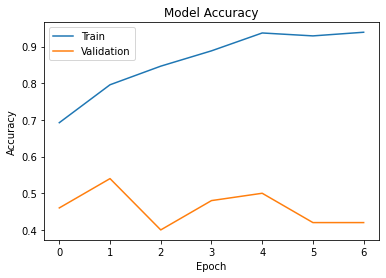

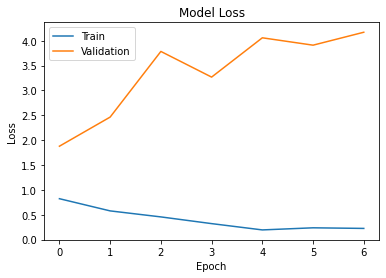

In [38]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [43]:
evaluate_model(model, X_val, y_val)

Accuracy: 0.54
[[5 1 3 0 1]
 [1 5 1 3 0]
 [0 1 6 0 3]
 [1 3 0 5 1]
 [0 2 2 0 6]]


As our datasize is restricted and the approach of VGG via transfer learning is still better in a pretty simple form, we will not try to extensively train a CNN in different settings and focus on two different pre trained transfer learning models for image classification. VGG, inception v3 and efficient_net b5.

## V. Transfer Learning

### V.I VGG

### V.II Inception v3

### V.III Efficinet Net B5